In [7]:
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# UMAP
try:
    import umap
except ImportError:
    raise ImportError("umap-learn이 없습니다. 터미널/노트북에서 `pip install umap-learn` 실행 후 다시 시도하세요.")

EXT = ".png"
SEED = 42
rng = np.random.default_rng(SEED)

DS_SIZE = 256
BIN_THR_TARGET = 0.5
N_TRAIN = 4000

PCA_DIM = 100
UMAP_DIM = 15
UMAP_NEIGHBORS = 15

print("SEED:", SEED)


SEED: 42


In [8]:

ROOT = Path(r"c:\Users\권나연\Desktop\나연\연세대학교\DSL\26-1\EDA\lithodata")

SET_A = "MetalSet"   # synthetic-like layout set (large)
SET_B = "StdMetal"   # standard-cell layout set (small)


def list_ids(set_dir: Path, mod: str) -> set:
    folder = set_dir / mod
    _bp = list(folder.rglob(f"*{EXT}"))
    return {p.stem for p in _bp}

def build_manifest(set_dir: Path, set_name: str, mods) -> pd.DataFrame:
    id_sets = {m: list_ids(set_dir, m) for m in mods}
    common = set.intersection(*[id_sets[m] for m in mods])
    if len(common) == 0:
        raise RuntimeError(f"{set_name}: 교집합 0. 폴더/파일명 규칙 확인 필요.")
    rows = []
    for bid in sorted(common):
        row = {"set": set_name, "base_id": bid}
        for m in mods:
            row[m] = str(set_dir / m / f"{bid}{EXT}")
        rows.append(row)
    return pd.DataFrame(rows)

# K 결정에는 target만 있으면 충분
man_A = build_manifest(ROOT/SET_A, SET_A, ["target"])
man_B = build_manifest(ROOT/SET_B, SET_B, ["target"])
N_B = len(man_B)

print("MetalSet count:", len(man_A))
print("StdMetal count (N_B):", N_B)


MetalSet count: 16472
StdMetal count (N_B): 271


In [4]:
def load_gray(path: Path) -> np.ndarray:
    img = Image.open(path).convert("L")
    arr = np.asarray(img, dtype=np.float32)
    if arr.max() > 1.0:
        arr /= 255.0
    return arr

def downsample_nearest(bin_img: np.ndarray, size=256) -> np.ndarray:
    pil = Image.fromarray((bin_img * 255).astype(np.uint8))
    pil = pil.resize((size, size), resample=Image.NEAREST)
    return (np.asarray(pil) > 0).astype(np.uint8)

def binarize_fixed(x01: np.ndarray, thr=0.5, auto_invert=True) -> np.ndarray:
    b = (x01 >= thr).astype(np.uint8)
    if auto_invert and b.mean() > 0.5:
        b = 1 - b
    return b

def embed_flat_target(path_str: str, thr=BIN_THR_TARGET, size=DS_SIZE) -> np.ndarray:
    x = load_gray(Path(path_str))
    b = binarize_fixed(x, thr, auto_invert=True)
    b = downsample_nearest(b, size=size)
    return b.reshape(-1).astype(np.float32)

n_train_actual = min(N_TRAIN, len(man_A))
train_idx = rng.choice(len(man_A), size=n_train_actual, replace=False)
man_train = man_A.iloc[train_idx].reset_index(drop=True)

X_train = np.stack([embed_flat_target(p) for p in man_train["target"].values], axis=0)
print("X_train shape:", X_train.shape)  # (n_train_actual, 256*256)


X_train shape: (4000, 65536)


[PCA] ...
Z_pca: (4000, 100) explained: 0.7811501026153564
[UMAP] ...
Z_umap: (4000, 15)


,K,silhouette,DBI,CH,min_cluster_size,zero_alloc_clusters,cv_alloc,alloc_deficit,L1_hist_mean,L1_hist_std,...,rank_sil,rank_dbi,rank_ch,rank_mincl,rank_zeroA,rank_cvA,rank_L1m,rank_L1s,rank_L1d,composite_rank
9,110,0.534802,0.722048,8059.153809,8,0,0.463375,0,0.025939,0.190011,...,7.0,5.0,10.0,8.5,6.0,7.0,3.5,17.0,3.5,72.5
6,80,0.537163,0.703319,7569.859863,8,0,0.416157,0,0.040699,0.152793,...,4.0,4.0,13.0,8.5,6.0,3.0,11.5,7.0,11.5,72.8
5,70,0.538253,0.688123,7167.355469,17,0,0.451468,0,0.048079,0.172611,...,3.0,3.0,14.0,6.0,6.0,5.0,15.5,10.0,15.5,80.9
15,170,0.533561,0.748503,8595.785156,3,12,0.464256,0,0.025939,0.099810,...,10.0,13.0,2.0,15.0,16.0,8.0,3.5,1.0,3.5,81.6
16,180,0.534605,0.756169,8507.920898,2,17,0.467427,0,0.018559,0.100127,...,8.0,16.0,4.0,17.5,17.0,9.0,1.0,2.0,1.0,84.6
11,130,0.541323,0.742021,8466.687500,7,0,0.497936,0,0.040699,0.174934,...,1.0,10.0,7.0,11.5,6.0,14.0,11.5,11.0,11.5,84.7
4,60,0.531482,0.665536,6874.196777,20,0,0.459983,0,0.040699,0.164085,...,14.0,1.0,15.0,5.0,6.0,6.0,11.5,8.0,11.5,86.0
10,120,0.539262,0.724163,8427.556641,7,1,0.482789,0,0.040699,0.182631,...,2.0,7.0,9.0,11.5,12.5,11.0,11.5,13.5,11.5,93.1
13,150,0.534827,0.743927,8482.956055,3,5,0.515338,0,0.033319,0.138351,...,6.0,11.0,6.0,15.0,14.0,17.0,7.0,5.0,7.0,93.4
14,160,0.532194,0.749969,8493.253906,3,8,0.510334,0,0.025939,0.130970,...,12.0,14.0,5.0,15.0,15.0,16.0,3.5,4.0,3.5,96.8



>>> Suggested K: 110


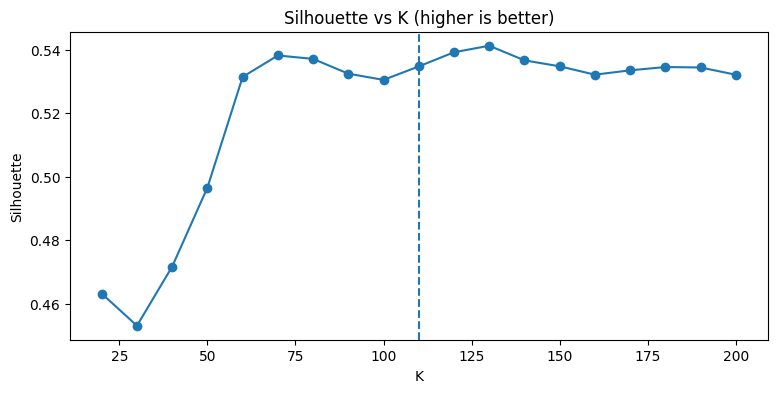

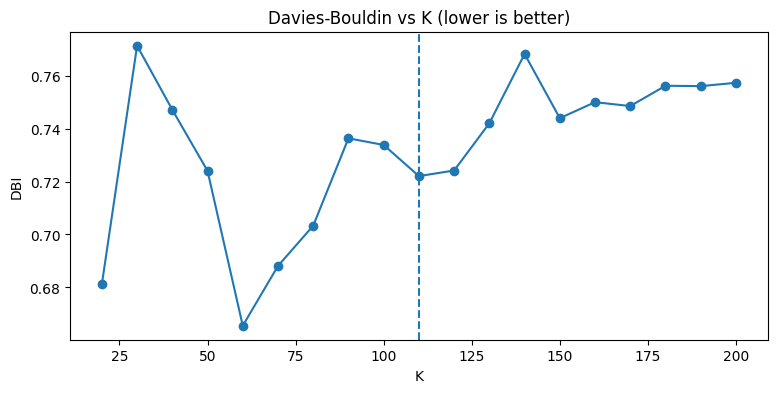

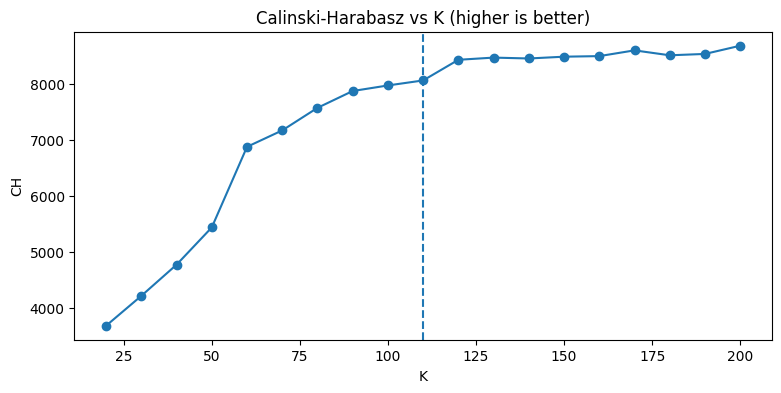

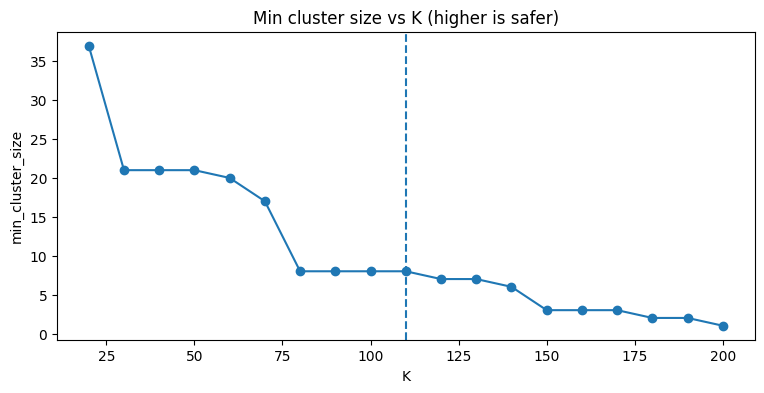

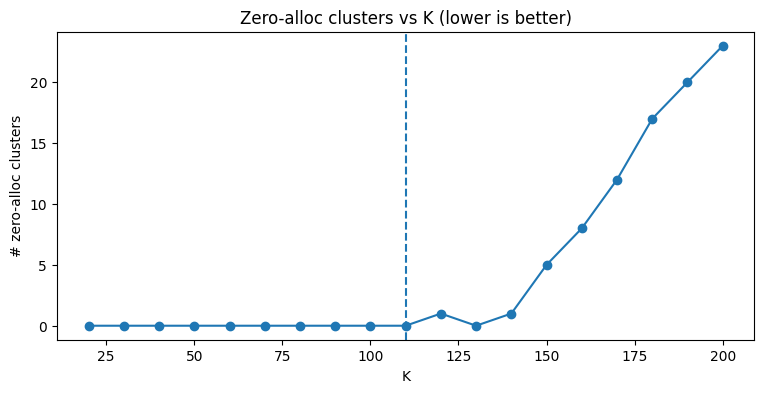

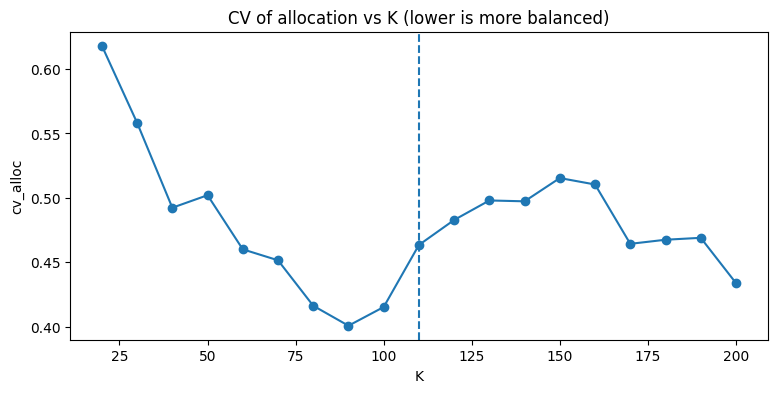

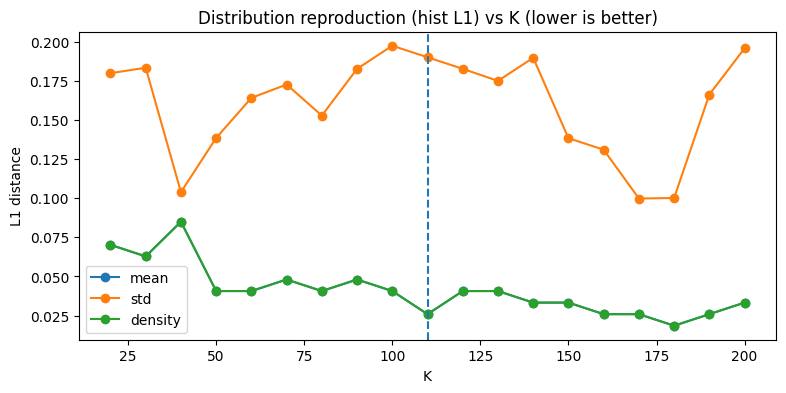

In [9]:
# ---------- (A) PCA -> UMAP ----------
print("[PCA] ...")
pca_reducer = PCA(n_components=PCA_DIM, random_state=SEED)
Z_pca = pca_reducer.fit_transform(X_train)
print("Z_pca:", Z_pca.shape, "explained:", float(pca_reducer.explained_variance_ratio_.sum()))

print("[UMAP] ...")
umap_reducer = umap.UMAP(
    n_components=UMAP_DIM,
    n_neighbors=UMAP_NEIGHBORS,
    min_dist=0.0,
    metric="euclidean",
    random_state=SEED,
    n_jobs=1
)
Z_umap = umap_reducer.fit_transform(Z_pca)
print("Z_umap:", Z_umap.shape)

# ---------- helper: allocation (대표 샘플링 진단용) ----------
def alloc_proportional(counts: np.ndarray, total_pick: int) -> dict:
    counts = counts.astype(int)
    N = counts.sum()
    weights = counts / max(N, 1)

    raw = weights * total_pick
    alloc = np.floor(raw).astype(int)
    rem = total_pick - alloc.sum()

    frac = raw - alloc
    order = np.argsort(-frac)
    if rem > 0:
        alloc[order[:rem]] += 1

    alloc_cap = np.minimum(alloc, counts)
    deficit = total_pick - alloc_cap.sum()

    if deficit > 0:
        capacity = counts - alloc_cap
        refill_order = np.argsort(-capacity)
        for k in refill_order:
            if deficit <= 0:
                break
            if capacity[k] <= 0:
                continue
            take = min(capacity[k], deficit)
            alloc_cap[k] += take
            deficit -= take

    zero_alloc = int(np.sum(alloc_cap == 0))
    pos_alloc = alloc_cap[alloc_cap > 0]
    min_alloc_pos = int(pos_alloc.min()) if len(pos_alloc) else 0
    cv_alloc = float(pos_alloc.std(ddof=0) / (pos_alloc.mean() + 1e-12)) if len(pos_alloc) else np.inf

    return {
        "alloc": alloc_cap,
        "zero_alloc_clusters": zero_alloc,
        "min_alloc_pos": min_alloc_pos,
        "cv_alloc": cv_alloc,
        "deficit_after_cap_and_refill": int(deficit),
    }

# ---------- helper: deterministic representative pick ----------
def deterministic_pick_by_centroid(Z: np.ndarray, labels: np.ndarray, centers: np.ndarray, alloc: np.ndarray) -> np.ndarray:
    chosen = []
    K = len(alloc)
    for k in range(K):
        a = int(alloc[k])
        if a <= 0:
            continue
        idx = np.where(labels == k)[0]
        if len(idx) == 0:
            continue
        dif = Z[idx] - centers[k]
        d2 = np.sum(dif * dif, axis=1)
        order = np.argsort(d2)
        take = min(a, len(idx))
        chosen.extend(idx[order[:take]].tolist())
    return np.array(chosen, dtype=np.int64)

# ---------- helper: distribution reproduction L1 (hist) ----------
def hist_l1_dist(a: np.ndarray, b: np.ndarray, bins: np.ndarray) -> float:
    ha, _ = np.histogram(a, bins=bins, density=False)
    hb, _ = np.histogram(b, bins=bins, density=False)
    pa = ha / max(ha.sum(), 1)
    pb = hb / max(hb.sum(), 1)
    return float(np.abs(pa - pb).sum())

X = X_train
feat_mean = X.mean(axis=1)     # density proxy
feat_std  = X.std(axis=1)
feat_den  = feat_mean

bins01 = np.linspace(0, 1, 21)
bins_std = np.linspace(0, max(0.6, float(feat_std.max()) + 1e-6), 21)

# ---------- (B) K sweep ----------
Z = Z_umap
n = Z.shape[0]

K_list = list(range(20, 201, 10))
rows = []

for K in K_list:
    km = KMeans(n_clusters=K, random_state=SEED, n_init="auto")
    labels = km.fit_predict(Z)
    centers = km.cluster_centers_

    sil = float(silhouette_score(Z, labels)) if K > 1 else np.nan
    dbi = float(davies_bouldin_score(Z, labels)) if K > 1 else np.nan
    ch  = float(calinski_harabasz_score(Z, labels)) if K > 1 else np.nan

    counts = np.bincount(labels, minlength=K)
    min_cluster = int(counts.min())

    alloc_info = alloc_proportional(counts, total_pick=int(N_B))
    alloc = alloc_info["alloc"]

    chosen = deterministic_pick_by_centroid(Z, labels, centers, alloc)
    if len(chosen) < N_B:
        pool = np.setdiff1d(np.arange(n), chosen, assume_unique=False)
        chosen = np.concatenate([chosen, pool[:(N_B - len(chosen))]])

    l1_mean = hist_l1_dist(feat_mean, feat_mean[chosen], bins01)
    l1_std  = hist_l1_dist(feat_std,  feat_std[chosen],  bins_std)
    l1_den  = hist_l1_dist(feat_den,  feat_den[chosen],  bins01)

    rows.append({
        "K": K,
        "silhouette": sil,
        "DBI": dbi,
        "CH": ch,
        "min_cluster_size": min_cluster,
        "zero_alloc_clusters": alloc_info["zero_alloc_clusters"],
        "cv_alloc": alloc_info["cv_alloc"],
        "alloc_deficit": alloc_info["deficit_after_cap_and_refill"],
        "L1_hist_mean": l1_mean,
        "L1_hist_std": l1_std,
        "L1_hist_density": l1_den,
    })

df = pd.DataFrame(rows)

# ---------- (C) composite ranking ----------
def rank_series(s, ascending=True):
    return s.rank(method="average", ascending=ascending)

df["rank_sil"]   = rank_series(df["silhouette"], ascending=False)
df["rank_dbi"]   = rank_series(df["DBI"], ascending=True)
df["rank_ch"]    = rank_series(df["CH"], ascending=False)
df["rank_mincl"] = rank_series(df["min_cluster_size"], ascending=False)
df["rank_zeroA"] = rank_series(df["zero_alloc_clusters"], ascending=True)
df["rank_cvA"]   = rank_series(df["cv_alloc"], ascending=True)
df["rank_L1m"]   = rank_series(df["L1_hist_mean"], ascending=True)
df["rank_L1s"]   = rank_series(df["L1_hist_std"], ascending=True)
df["rank_L1d"]   = rank_series(df["L1_hist_density"], ascending=True)

df["composite_rank"] = (
    1.5*df["rank_sil"] +
    1.0*df["rank_dbi"] +
    1.0*df["rank_ch"] +
    1.2*df["rank_mincl"] +
    1.2*df["rank_zeroA"] +
    0.8*df["rank_cvA"] +
    1.0*df["rank_L1m"] +
    1.0*df["rank_L1s"] +
    1.0*df["rank_L1d"]
)

df_sorted = df.sort_values(["composite_rank", "alloc_deficit", "zero_alloc_clusters"],
                           ascending=[True, True, True])
bestK = int(df_sorted.iloc[0]["K"])

display(df_sorted)
print("\n>>> Suggested K:", bestK)

# ---------- (D) plots ----------
Ks = df["K"].values

def plot_metric(y, title, ylabel):
    fig, ax = plt.subplots(figsize=(9, 4))
    ax.plot(Ks, y, marker="o")
    ax.axvline(bestK, linestyle="--")
    ax.set_title(title)
    ax.set_xlabel("K")
    ax.set_ylabel(ylabel)
    plt.show()

plot_metric(df["silhouette"].values, "Silhouette vs K (higher is better)", "Silhouette")
plot_metric(df["DBI"].values, "Davies-Bouldin vs K (lower is better)", "DBI")
plot_metric(df["CH"].values, "Calinski-Harabasz vs K (higher is better)", "CH")

plot_metric(df["min_cluster_size"].values, "Min cluster size vs K (higher is safer)", "min_cluster_size")
plot_metric(df["zero_alloc_clusters"].values, "Zero-alloc clusters vs K (lower is better)", "# zero-alloc clusters")
plot_metric(df["cv_alloc"].values, "CV of allocation vs K (lower is more balanced)", "cv_alloc")

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(Ks, df["L1_hist_mean"].values, marker="o", label="mean")
ax.plot(Ks, df["L1_hist_std"].values, marker="o", label="std")
ax.plot(Ks, df["L1_hist_density"].values, marker="o", label="density")
ax.axvline(bestK, linestyle="--")
ax.set_title("Distribution reproduction (hist L1) vs K (lower is better)")
ax.set_xlabel("K")
ax.set_ylabel("L1 distance")
ax.legend()
plt.show()


In [ ]:
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# UMAP 라이브러리 임포트 (설치 필요: pip install umap-learn)
try:
    import umap
except ImportError:
    raise ImportError("umap-learn 라이브러리가 없습니다. '!pip install umap-learn'을 먼저 실행해주세요.")

# =============================================================================
# 1. 설정 및 상수 정의 (환경에 맞게 수정하세요)
# =============================================================================
SEED = 42
rng = np.random.default_rng(SEED)

# 경로 및 데이터 설정
ROOT = Path(".")  # 데이터가 있는 최상위 경로 (필요 시 수정: Path("D:/Data"))
SET_A = "MetalSet"      # 원본 데이터셋 이름
SET_B = "StdMetal"      # 기준 데이터셋 (개수 참조용)
MODS_STAGE = ["target"] # 사용할 모달리티
EXT = ".png"            # 이미지 확장자

# 하이퍼파라미터
DS_SIZE = 256           # 다운샘플링 크기
BIN_THR_TARGET = 0.5    # 이진화 임계값
N_TRAIN = 5000          # 매니폴드 학습에 사용할 subset 크기 (전체가 너무 크면 일부만 사용)
K_CLUSTER = 150          # 최종 클러스터 개수(여기 수정!!!!)
BATCH_SIZE = 1024       # 추론 시 배치 크기

# PCA & UMAP 설정
PCA_DIM = 100           # 1차 압축 차원 (노이즈 제거용)
UMAP_DIM = 15           # 2차 압축 차원 (매니폴드 학습용)
UMAP_NEIGHBORS = 15     # UMAP 이웃 수

# 2. 유틸리티 함수 정의
def load_gray(path: Path) -> np.ndarray:
    img = Image.open(path).convert("L")
    arr = np.asarray(img, dtype=np.float32)
    if arr.max() > 1.0:
        arr /= 255.0
    return arr

def downsample_nearest(bin_img: np.ndarray, size=256) -> np.ndarray:
    pil = Image.fromarray((bin_img * 255).astype(np.uint8))
    pil = pil.resize((size, size), resample=Image.NEAREST)
    return (np.asarray(pil) > 0).astype(np.uint8)

def binarize_fixed(x: np.ndarray, thr=0.5, auto_invert=True) -> np.ndarray:
    b = (x >= thr).astype(np.uint8)
    if auto_invert and b.mean() > 0.5:
        b = 1 - b
    return b

def list_ids(set_dir: Path, mod: str) -> set:
    folder = set_dir / mod
    paths = list(folder.rglob(f"*{EXT}"))
    return {p.stem for p in paths}

def build_manifest(set_name: str, mods) -> pd.DataFrame:
    set_dir = ROOT / set_name
    # 폴더가 실제로 있는지 확인
    if not set_dir.exists():
        print(f"Warning: {set_dir} 경로를 찾을 수 없습니다. 테스트용 더미 데이터를 생성합니다.")
        # 코드가 멈추지 않도록 테스트용 더미 데이터프레임 생성 (실제 사용시에는 이 부분 무시됨)
        return pd.DataFrame({"set": [set_name]*10, "base_id": [f"id_{i}" for i in range(10)], "target": [f"dummy_{i}.png" for i in range(10)]})
        
    id_sets = {m: list_ids(set_dir, m) for m in mods}
    if not id_sets[mods[0]]: # 파일이 하나도 없으면
         raise RuntimeError(f"{set_dir} 내부에 {EXT} 파일이 없습니다.")

    common = set.intersection(*[id_sets[m] for m in mods])
    if len(common) == 0:
        raise RuntimeError(f"{set_name}: {mods} stem 교집합이 0입니다. 파일명 규칙 확인 필요.")
    
    rows = []
    for bid in sorted(common):
        row = {"set": set_name, "base_id": bid}
        for m in mods:
            row[m] = str(set_dir / m / f"{bid}{EXT}")
        rows.append(row)
    return pd.DataFrame(rows)

def embed_flat_target(path_str: str, thr=BIN_THR_TARGET, size=DS_SIZE) -> np.ndarray:
    # 파일이 없으면 0으로 채운 더미 리턴 (테스트 안전장치)
    if not Path(path_str).exists() and "dummy" in path_str:
        return np.zeros(size*size, dtype=np.float32)
        
    x = load_gray(Path(path_str))
    b = binarize_fixed(x, thr, auto_invert=True)
    b = downsample_nearest(b, size=size) 
    return b.reshape(-1).astype(np.float32)

# =============================================================================
# 3. 데이터 로드 및 준비
# =============================================================================
print(">>> 데이터 매니페스트 생성 중...")
# 실제 경로가 세팅되어야 돌아갑니다. 경로가 없다면 에러가 날 수 있습니다.
try:
    man_A = build_manifest(SET_A, MODS_STAGE)
    # man_B는 개수만 필요하므로 실제 파일이 없다면 임의의 숫자로 가정
    try:
        man_B = build_manifest(SET_B, MODS_STAGE)
        N_B = len(man_B)
    except:
        print(f"{SET_B} 경로 확인 불가, 목표 샘플 수를 271로 고정합니다.")
        N_B = 271
except Exception as e:
    print(f"오류 발생: {e}")
    print("경로 설정을 확인해주세요. 코드를 중단합니다.")
    # raise e # 실제 실행 시에는 주석 해제

print(f"{SET_A} Count: {len(man_A)}")
print(f"Target Sample Count ({SET_B}): {N_B}")

# (1) 학습용 Subset 선택 (전체 데이터 패턴 학습용)
n_train_actual = min(N_TRAIN, len(man_A))
train_idx = rng.choice(len(man_A), size=n_train_actual, replace=False)
man_train = man_A.iloc[train_idx].reset_index(drop=True)

print(f">>> 학습 데이터 로딩 중 (Subset: {n_train_actual}개)...")
X_train = np.stack([embed_flat_target(p) for p in man_train["target"].values], axis=0)
print(f"X_train shape: {X_train.shape}") # (N, 65536)

# =============================================================================
# 4. 모델 파이프라인 (PCA -> UMAP -> KMeans)
# =============================================================================

# Step 1: PCA (노이즈 제거 및 차원 축소 65536 -> 100)
print("\n[Step 1] PCA: Noise Reduction...")
pca_reducer = PCA(n_components=PCA_DIM, random_state=SEED)
Z_pca = pca_reducer.fit_transform(X_train)
print(f"PCA Done. Shape: {Z_pca.shape} (Var: {np.sum(pca_reducer.explained_variance_ratio_):.4f})")

# Step 2: UMAP (비선형 매니폴드 학습 100 -> 15)
# 노트북 CPU 부하를 고려하여 n_jobs=1 설정, metric='euclidean'
print("\n[Step 2] UMAP: Manifold Learning (Non-linear)...")
umap_reducer = umap.UMAP(
    n_components=UMAP_DIM,
    n_neighbors=UMAP_NEIGHBORS,
    min_dist=0.0,      # 클러스터링을 위해 데이터를 뭉치게 함
    metric='euclidean',
    random_state=SEED,
    n_jobs=1 
)
Z_umap = umap_reducer.fit_transform(Z_pca)
print(f"UMAP Done. Shape: {Z_umap.shape}")

# Step 3: KMeans (대표 군집 탐색)
print(f"\n[Step 3] KMeans Clustering (k={K_CLUSTER})...")
km = KMeans(n_clusters=K_CLUSTER, random_state=SEED, n_init="auto")
km.fit(Z_umap)
print("KMeans Fitted.")

# =============================================================================
# 5. 전체 데이터 라벨링 (Batch Inference)
# =============================================================================
print("\n>>> 전체 데이터 라벨링 시작 (Batch Processing)...")
labels_all = np.empty(len(man_A), dtype=np.int32)

for s in range(0, len(man_A), BATCH_SIZE):
    e = min(s + BATCH_SIZE, len(man_A))
    paths = man_A["target"].values[s:e]
    
    # 로드 -> PCA -> UMAP -> KMeans Predict
    Xb = np.stack([embed_flat_target(p) for p in paths], axis=0)
    Zb_pca = pca_reducer.transform(Xb)
    Zb_umap = umap_reducer.transform(Zb_pca) # UMAP transform은 PCA보다 느릴 수 있음
    labels_all[s:e] = km.predict(Zb_umap)
    
    if (s // BATCH_SIZE) % 5 == 0:
        print(f"Processed: {e}/{len(man_A)}")

# =============================================================================
# 6. 층화 추출 (Stratified Sampling)
# =============================================================================
print("\n>>> 대표 샘플 추출 중...")
counts = np.bincount(labels_all, minlength=K_CLUSTER)
weights = counts / counts.sum()

# 목표 개수(N_B)에 맞춰 할당
alloc = np.floor(weights * N_B).astype(int)
rem = N_B - alloc.sum()

# 소수점 남은 부분 처리를 위해 내림차순 정렬 후 추가 할당
frac = (weights * N_B) - alloc
order = np.argsort(-frac)
for j in order[:rem]:
    alloc[j] += 1

chosen_indices = []
for k in range(K_CLUSTER):
    idx_k = np.where(labels_all == k)[0]
    if len(idx_k) == 0 or alloc[k] == 0:
        continue
    
    # 해당 클러스터 내에서 랜덤 추출 (중심점에 가까운 걸 뽑으려면 거리 계산 필요하지만, 랜덤도 무방)
    pick = rng.choice(idx_k, size=min(alloc[k], len(idx_k)), replace=False)
    chosen_indices.extend(pick.tolist())

chosen_indices = np.array(chosen_indices, dtype=np.int64)

# 혹시 모자라면 전체 풀에서 랜덤 보충
if len(chosen_indices) < N_B:
    print(f"Warning: {N_B - len(chosen_indices)} samples insufficient. Filling randomly.")
    pool = np.setdiff1d(np.arange(len(man_A)), chosen_indices)
    add = rng.choice(pool, size=(N_B - len(chosen_indices)), replace=False)
    chosen_indices = np.concatenate([chosen_indices, add])

print(f"최종 추출 완료: {len(chosen_indices)}장 (Target: {N_B})")

# =============================================================================
# 7. 결과 저장
# =============================================================================
man_A_s = man_A.iloc[chosen_indices].reset_index(drop=True)
man_A_s["cluster"] = labels_all[chosen_indices]

save_path = ROOT / "manifest_MetalSet_rep271_PCA_UMAP_KMeans.csv"
man_A_s.to_csv(save_path, index=False)
print(f"\n[Success] Manifest saved to: {save_path}")